# Five-Step Agent Performance Analysis
This notebook provides comprehensive visualizations showing all five steps of the agent's performance in unified plots.

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages

# Load data
df = pd.read_csv('/global/cfs/projectdirs/atlas/joshua/llm4hep/results_summary.csv', comment='#')

# Remove rows with missing supervisor or coder
df = df.dropna(subset=['supervisor', 'coder'])

# Model name mapping from CBORG aliases to cleaner display names with version dates
# Based on testing with CBORG API on October 29, 2025
# Dates reflect actual underlying model versions discovered via API testing
MODEL_NAME_MAPPING = {
    # Anthropic Claude models (with version dates from API testing)
    'anthropic/claude-haiku:latest': 'Claude Haiku 4.5 (2025-10-01)',  # claude-haiku-4-5@20251001
    'anthropic/claude-opus:latest': 'Claude Opus 4.1 (2025-08-05)',   # us.anthropic.claude-opus-4-1-20250805-v1:0
    'anthropic/claude-sonnet:latest': 'Claude Sonnet 4.5 (2025-09-29)', # claude-sonnet-4-5@20250929
    'claude-3-5-haiku-latest': 'Claude 3.5 Haiku (2024-10-22)',        # claude-3-5-haiku@20241022
    
    # Google Gemini (from CBORG mapping test)
    'google/gemini:latest': 'Gemini 2.5 Pro',          # gemini-2.5-pro
    'google/gemini-flash': 'Gemini 2.5 Flash',         # gemini-2.5-flash
    'gemini-2.0-flash-lite': 'Gemini 2.0 Flash Lite',  # (no alias)
    
    # OpenAI models (with version dates from API testing)
    # Note: openai/o:latest and openai/o3 both map to azure/o3-2025-04-16 (same model, merged in plots)
    'openai/o:latest': 'O3 (2025-04-16)',       # azure/o3-2025-04-16 (aliased)
    'openai/gpt-5': 'GPT-5 (2025-08-07)',       # gpt-5-2025-08-07
    'openai/gpt-5-mini': 'GPT-5 Mini (2025-08-07)', # gpt-5-mini-2025-08-07
    'openai/o3': 'O3 (2025-04-16)',             # azure/o3-2025-04-16 (direct, same as o:latest)
    'openai/o3-mini': 'O3 Mini (2025-01-31)',   # azure/o3-mini-2025-01-31
    'openai/o4-mini': 'O4 Mini (2025-04-16)',   # azure/o4-mini-2025-04-16
    
    # xAI Grok (from CBORG mapping test)
    'xai/grok:latest': 'Grok-3',                # grok-3
    'xai/grok-mini': 'Grok Mini',               # Rate limited during test
    'xai/grok-code-fast-1': 'Grok Code Fast 1', # Rate limited during test
    
    # AWS models (with version info from API testing)
    'aws/llama-4-maverick': 'Llama-4 Maverick (17B)',  # us.meta.llama4-maverick-17b-instruct-v1:0
    'aws/llama-4-scout': 'Llama-4 Scout (17B)',        # us.meta.llama4-scout-17b-instruct-v1:0
    
    # Other models (with version info where available)
    'gpt-oss-120b': 'GPT-OSS-120B',     # hosted_vllm/hosted_vllm/gpt-oss-120b
    'gpt-5-codex': 'GPT-5 Codex',       # Model not accessible during test
    'deepseek-r1': 'DeepSeek-R1',       # MAI-DS-R1
    'gcp/qwen-3': 'Qwen-3 (235B)',      # qwen/qwen3-235b-a22b-instruct-2507-maas
}

def resolve_model_name(model_alias):
    """Convert CBORG alias to actual model name."""
    if pd.isna(model_alias):
        return model_alias
    model_str = str(model_alias).strip()
    return MODEL_NAME_MAPPING.get(model_str, model_str)

# Create pair label - only show model once if supervisor and coder are the same
def create_pair_label(row):
    supervisor = resolve_model_name(row['supervisor'])
    coder = resolve_model_name(row['coder'])
    if supervisor == coder:
        return supervisor
    else:
        return supervisor + ' / ' + coder

df['pair'] = df.apply(create_pair_label, axis=1)

# Filter to only include pairs that have all 5 steps
required_steps = set([1.0, 2.0, 3.0, 4.0, 5.0])
pairs_with_all_steps = (
    df.groupby('pair')['step']
    .apply(lambda steps: required_steps.issubset(set(steps)))
)
valid_pairs = pairs_with_all_steps[pairs_with_all_steps].index
df_filtered = df[df['pair'].isin(valid_pairs)].copy()

print(f"Total records before filtering: {len(df)}")
print(f"Total records after filtering: {len(df_filtered)}")
print(f"Pairs before filtering: {df['pair'].nunique()}")
print(f"Pairs after filtering (with all 5 steps): {df_filtered['pair'].nunique()}")
print(f"Steps: {sorted(df_filtered['step'].unique())}")
print(f"\nPairs removed (incomplete steps): {df['pair'].nunique() - df_filtered['pair'].nunique()}")

# Use filtered dataframe for all subsequent analysis
df = df_filtered

print(f"\nFirst few rows:")
df.head()

Total records before filtering: 1484
Total records after filtering: 1484
Pairs before filtering: 21
Pairs after filtering (with all 5 steps): 21
Steps: [1.0, 2.0, 3.0, 4.0, 5.0]

Pairs removed (incomplete steps): 0

First few rows:


supervisor                          coder  step  \
0  anthropic/claude-haiku:latest  anthropic/claude-haiku:latest   1.0   
1  anthropic/claude-haiku:latest  anthropic/claude-haiku:latest   1.0   
2  anthropic/claude-haiku:latest  anthropic/claude-haiku:latest   1.0   
3  anthropic/claude-haiku:latest  anthropic/claude-haiku:latest   1.0   
4  anthropic/claude-haiku:latest  anthropic/claude-haiku:latest   1.0   

   success  iterations   duration  API_calls  input_tokens  output_tokens  \
0     True         2.0  55.143727        5.0        4735.0         2744.0   
1     True         2.0  47.449918        5.0        4580.0         2573.0   
2     True         2.0  52.088826        5.0        4864.0         2876.0   
3     True         2.0  48.873033        5.0        4556.0         2573.0   
4     True         2.0  48.709284        5.0        4738.0         2661.0   

   user_prompt_tokens  supervisor_to_coder_tokens  coder_output_tokens  \
0               460.0                       854.0               1617.0   
1               460.0                       863.0               1524.0   
2               460.0                       877.0               1670.0   
3               460.0                       879.0               1437.0   
4               460.0                       858.0               1619.0   

   feedback_to_supervisor_tokens error error_description  \
0                         3421.0   NaN               NaN   
1                         3257.0   NaN               NaN   
2                         3527.0   NaN               NaN   
3                         3217.0   NaN               NaN   
4                         3420.0   NaN               NaN   

                                          output_dir  \
0  /global/cfs/projectdirs/atlas/llm4hep/oct_10_t...   
1  /global/cfs/projectdirs/atlas/llm4hep/oct_10_t...   
2  /global/cfs/projectdirs/atlas/llm4hep/oct_10_t...   
3  /global/cfs/projectdirs/atlas/llm4hep/oct_10_t...   
4  /global/cfs/projectdirs/atlas/llm4hep/oct_10_t...   

                            pair  
0  Claude Haiku 4.5 (2025-10-01)  
1  Claude Haiku 4.5 (2025-10-01)  
2  Claude Haiku 4.5 (2025-10-01)  
3  Claude Haiku 4.5 (2025-10-01)  
4  Claude Haiku 4.5 (2025-10-01)

## 1. Success Rate Across All Steps (Heatmap)

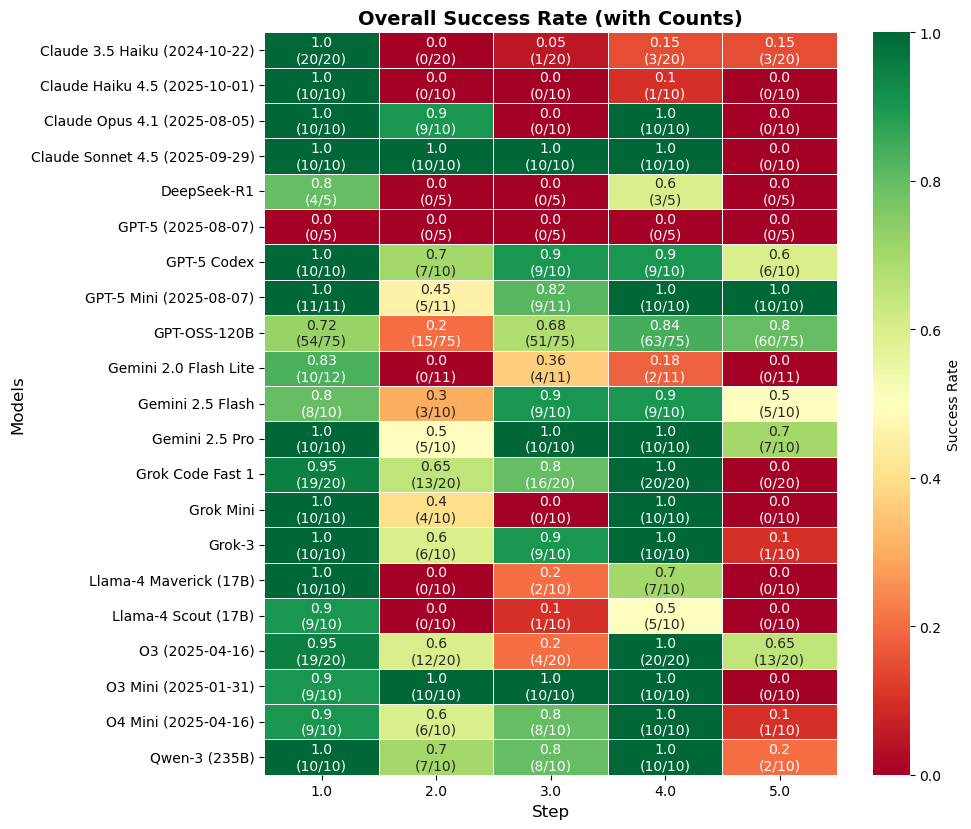

In [83]:
# Calculate success rate by pair and step
success_summary = (
    df.groupby(['pair', 'step'])
    .agg(
        success_rate=('success', 'mean'),
        n_success=('success', 'sum'),
        n_total=('success', 'count')
    )
    .reset_index()
)

# Pivot for heatmap
pivot_rate = success_summary.pivot(index='pair', columns='step', values='success_rate')
pivot_succ = success_summary.pivot(index='pair', columns='step', values='n_success')
pivot_tot = success_summary.pivot(index='pair', columns='step', values='n_total')

# Create annotations with success rate and counts
annot = pivot_rate.round(2).astype(str) + "\n(" + \
        pivot_succ.fillna(0).astype(int).astype(str) + "/" + \
        pivot_tot.fillna(0).astype(int).astype(str) + ")"

# Plot heatmap
fig, ax = plt.subplots(figsize=(10, max(8, len(pivot_rate) * 0.4)))
sns.heatmap(
    pivot_rate,
    annot=annot,
    fmt='',
    cmap='RdYlGn',
    vmin=0,
    vmax=1,
    linewidths=0.5,
    cbar_kws={'label': 'Success Rate'},
    ax=ax
)
ax.set_title('Overall Success Rate (with Counts)', fontsize=14, fontweight='bold') # Success Rate Across All Steps\n(Rate and n_success/n_total)
ax.set_xlabel('Step', fontsize=12)
ax.set_ylabel('Models', fontsize=12)
plt.tight_layout()
plt.savefig('plots/1_success_rate_heatmap.png', dpi=300, bbox_inches='tight')
plt.savefig('plots/1_success_rate_heatmap.pdf', bbox_inches='tight')
plt.show()

## 2. Agent Work Across All Steps (Line Plot with Error Bars)

Removed 1 rows with invalid user_prompt_tokens (0 or NaN)
Pairs with at least one success in all 5 steps: 9


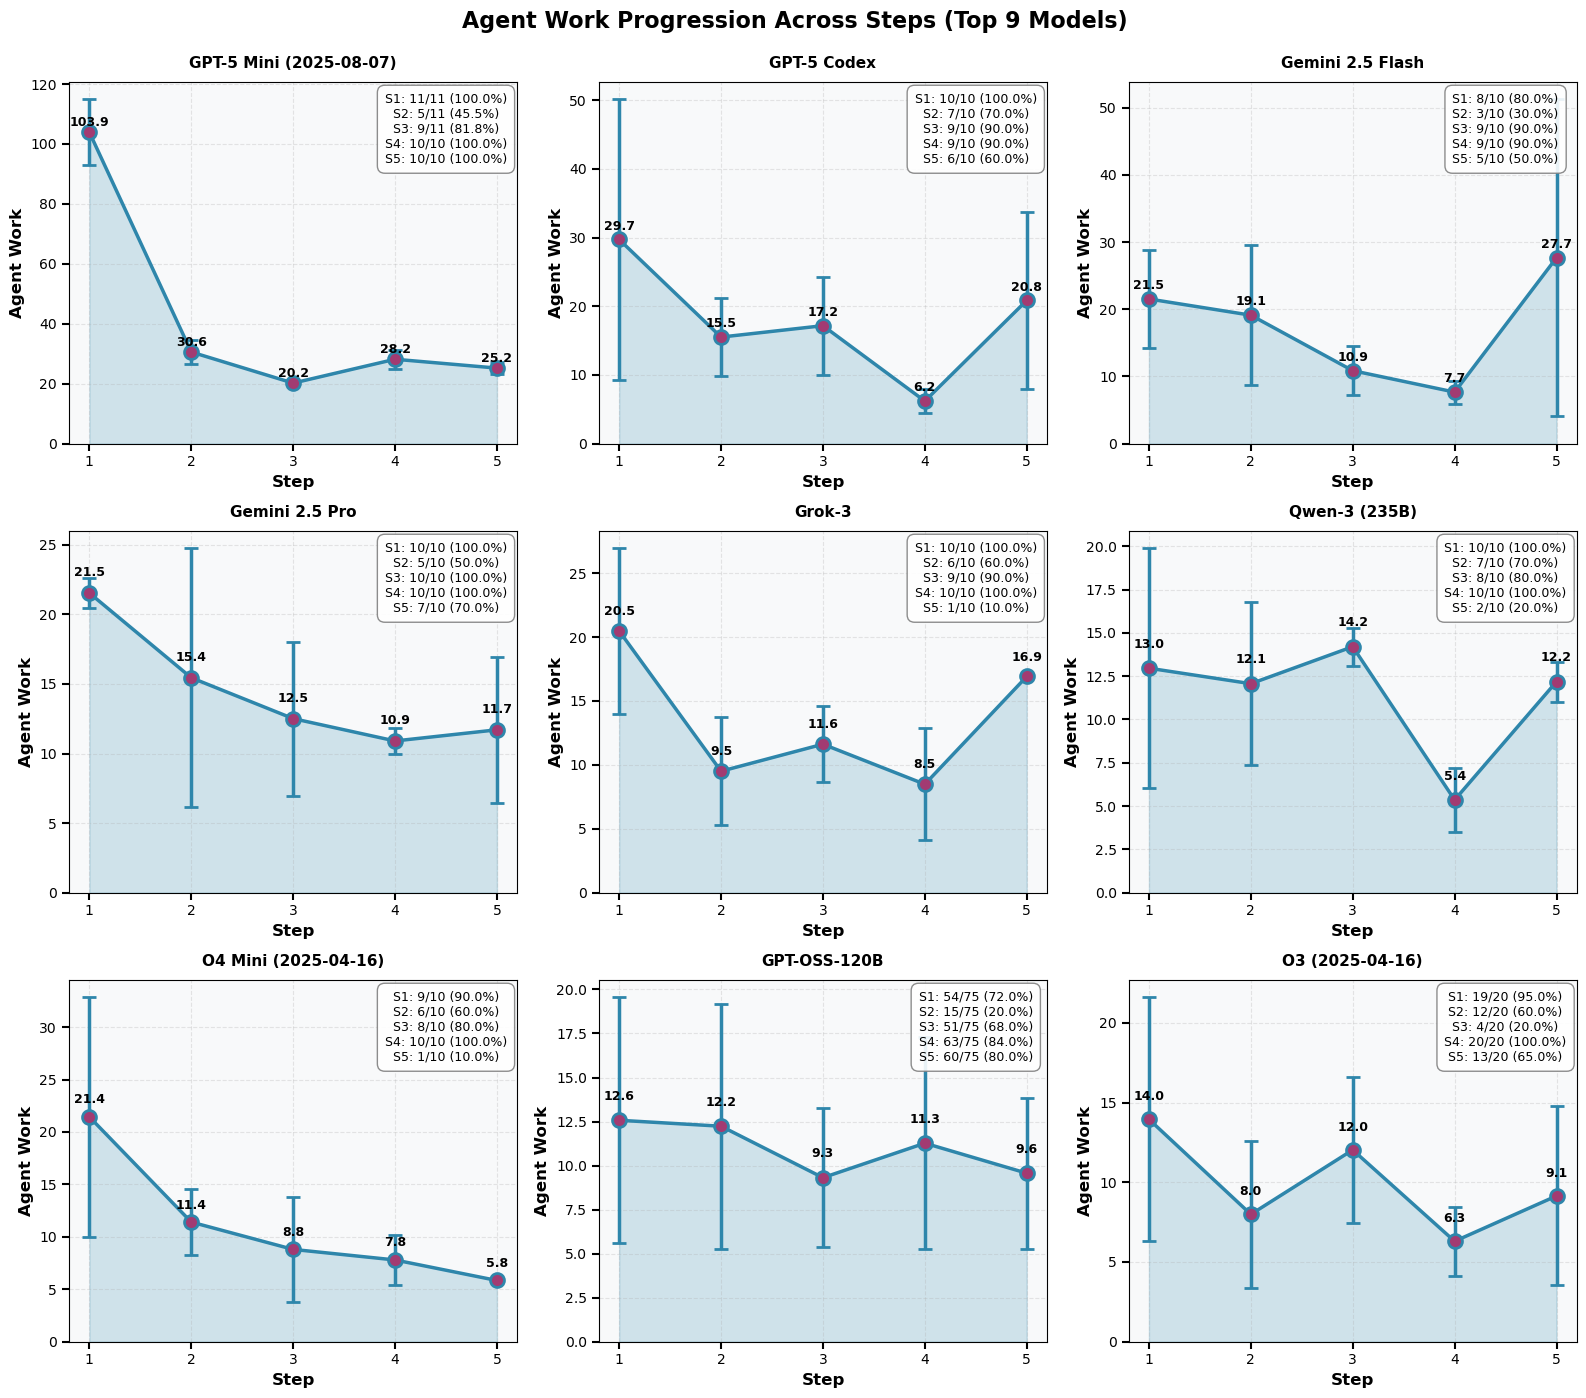

In [84]:
# Filter successful trials and compute agent work
df_success = df[df['success'] == True].copy()

# Remove rows with invalid user_prompt_tokens (0 or NaN) - these are data errors
before_filtering = len(df_success)
df_success = df_success[(df_success['user_prompt_tokens'] > 0) & (df_success['user_prompt_tokens'].notna())]
after_filtering = len(df_success)
if before_filtering > after_filtering:
    print(f"Removed {before_filtering - after_filtering} rows with invalid user_prompt_tokens (0 or NaN)")

df_success['agent_work'] = (
    df_success['input_tokens'] + df_success['output_tokens'] - df_success['user_prompt_tokens']
) / df_success['user_prompt_tokens']

# Filter to only include pairs with at least one success in all 5 steps
required_steps = set([1.0, 2.0, 3.0, 4.0, 5.0])
pairs_with_all_steps_success = (
    df_success.groupby('pair')['step']
    .apply(lambda steps: required_steps.issubset(set(steps)))
)
valid_pairs_success = pairs_with_all_steps_success[pairs_with_all_steps_success].index
df_success = df_success[df_success['pair'].isin(valid_pairs_success)].copy()

print(f"Pairs with at least one success in all 5 steps: {len(valid_pairs_success)}")

# Group by pair and step
work_stats = (
    df_success.groupby(['pair', 'step'])['agent_work']
    .agg(['mean', 'std', 'count'])
    .reset_index()
)

# Plot top 9 pairs by average work (for 3x3 grid)
top_pairs = (
    work_stats.groupby('pair')['mean']
    .mean()
    .sort_values(ascending=False)
    .head(9)
    .index
)

# Calculate success rates per step for each pair
success_by_step = (
    df[df['pair'].isin(top_pairs)]
    .groupby(['pair', 'step'])
    .agg(
        n_success=('success', 'sum'),
        n_total=('success', 'count')
    )
    .reset_index()
)

# Create 3x3 faceted plot
fig, axes = plt.subplots(3, 3, figsize=(16, 14))
axes = axes.flatten()

for idx, pair in enumerate(top_pairs):
    ax = axes[idx]
    pair_data = work_stats[work_stats['pair'] == pair].sort_values('step')
    
    # Plot line with error bars
    ax.errorbar(
        pair_data['step'],
        pair_data['mean'],
        yerr=pair_data['std'],
        marker='o',
        color='#2E86AB',
        capsize=5,
        linewidth=2.5,
        markersize=10,
        markerfacecolor='#A23B72',
        markeredgewidth=2,
        markeredgecolor='#2E86AB'
    )
    
    # Fill area under curve for visual effect
    ax.fill_between(pair_data['step'], 0, pair_data['mean'], alpha=0.2, color='#2E86AB')
    
    # Add value labels on each point
    for _, row in pair_data.iterrows():
        ax.text(row['step'], row['mean'] + 1, f"{row['mean']:.1f}", 
               ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Get success info per step for legend text box
    pair_success = success_by_step[success_by_step['pair'] == pair].sort_values('step')
    legend_text = []
    for _, row in pair_success.iterrows():
        step = int(row['step'])
        n_succ = int(row['n_success'])
        n_tot = int(row['n_total'])
        success_rate = (n_succ / n_tot * 100) if n_tot > 0 else 0
        legend_text.append(f"S{step}: {n_succ}/{n_tot} ({success_rate:.1f}%)")
    
    # Formatting with simple title
    ax.set_title(pair, fontsize=11, fontweight='bold', pad=10)
    ax.set_xlabel('Step', fontsize=12, fontweight='bold')
    ax.set_ylabel('Agent Work', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_xticks([1, 2, 3, 4, 5])
    ax.set_ylim(bottom=0)
    
    # Make tick labels more visible
    ax.tick_params(axis='both', which='major', labelsize=10, width=1.5, length=5)
    
    # Add text box with success rates per step, positioned between step 4 and 5
    textstr = '\n'.join(legend_text)
    props = dict(boxstyle='round,pad=0.6', facecolor='white', alpha=0.9, edgecolor='gray', linewidth=1)
    ax.text(4.5, ax.get_ylim()[1] * 0.97, textstr, fontsize=9,
            verticalalignment='top', horizontalalignment='center', bbox=props)
    
    # Add light background color
    ax.set_facecolor('#F8F9FA')

fig.suptitle('Agent Work Progression Across Steps (Top 9 Models)', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('plots/2_agent_work_line_plot.png', dpi=300, bbox_inches='tight')
plt.savefig('plots/2_agent_work_line_plot.pdf', bbox_inches='tight')
plt.show()


## 3. API Calls Across All Steps (Grouped Bar Plot)

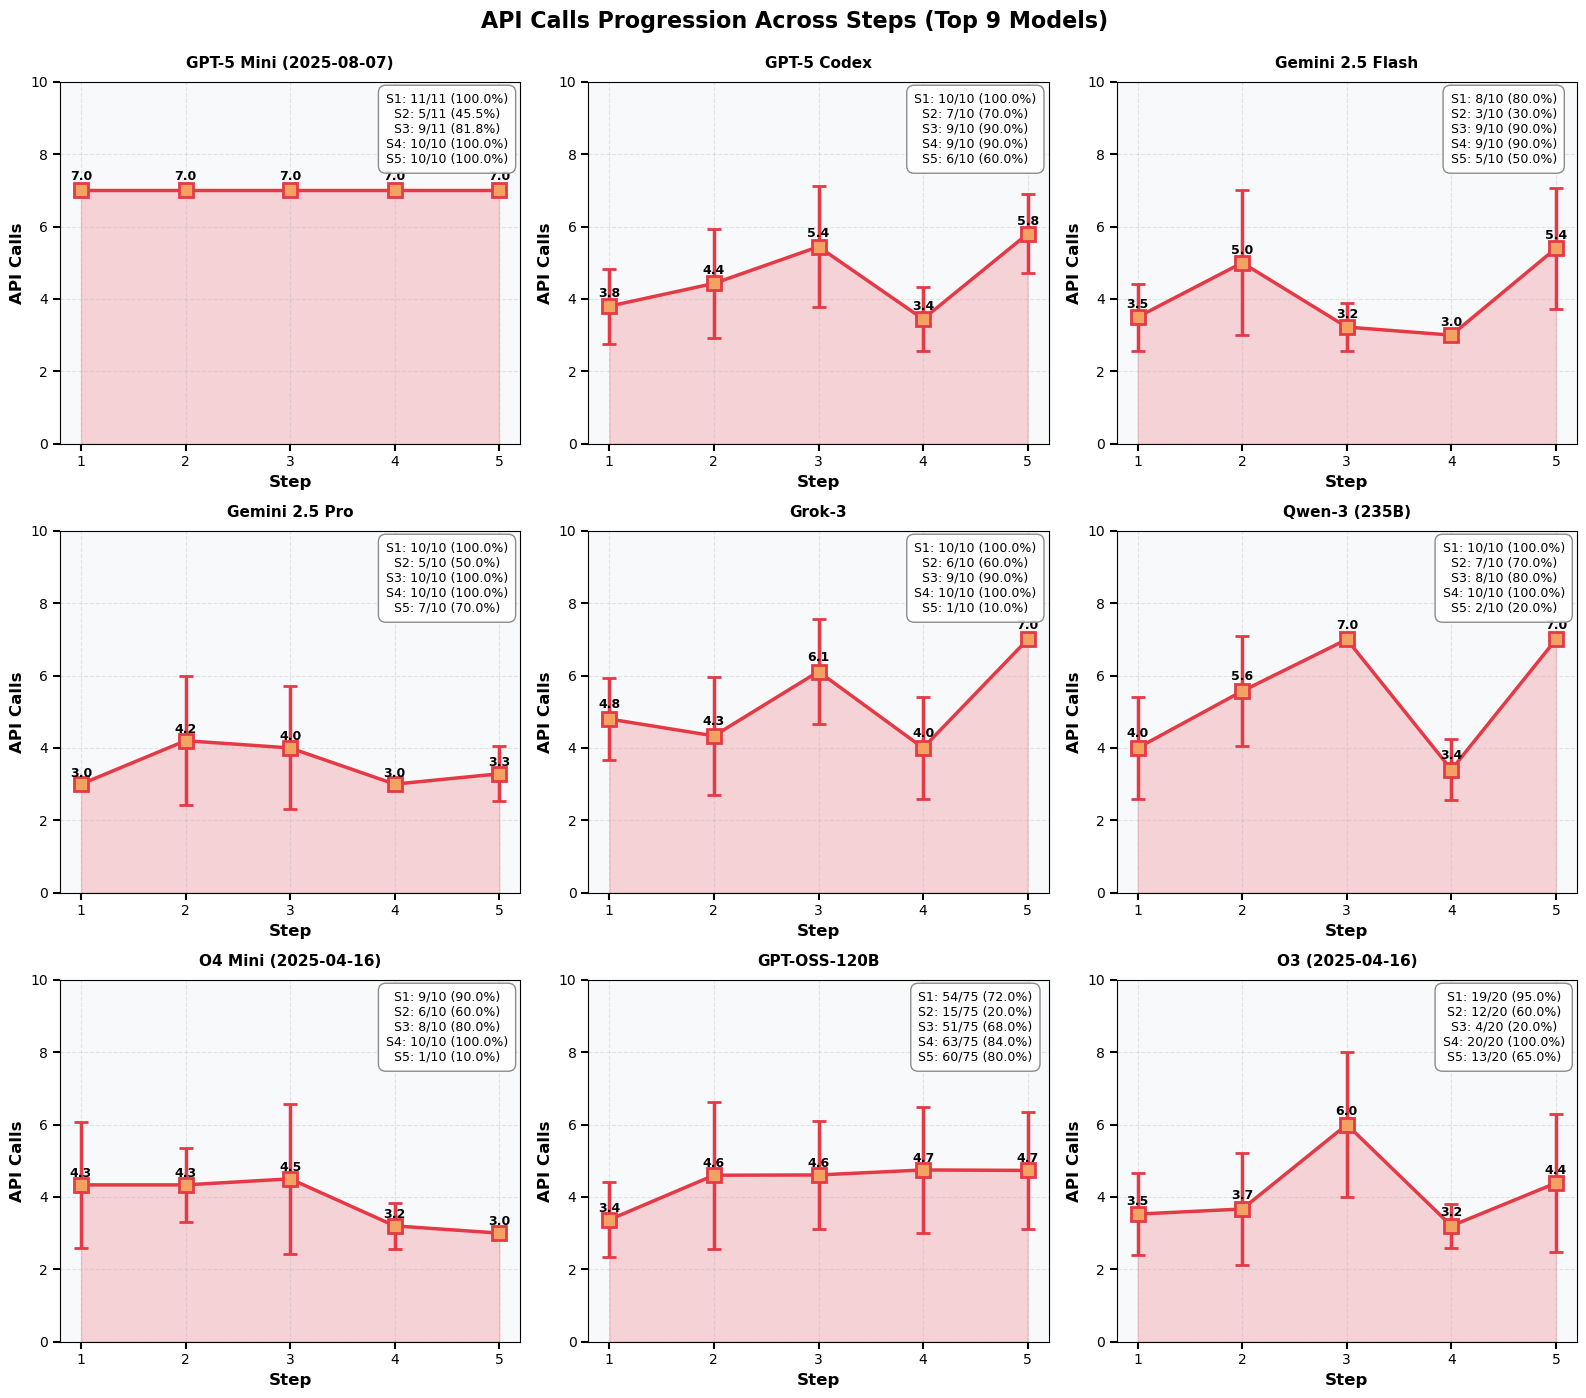

In [85]:
# Compute API call statistics
api_stats = (
    df_success.groupby(['pair', 'step'])['API_calls']
    .agg(['mean', 'std', 'count'])
    .reset_index()
)

# Use the same top 9 pairs from Agent Work plot for consistency
top_pairs_api = top_pairs

# Calculate success rates per step for each pair (for legend)
success_by_step_api = (
    df[df['pair'].isin(top_pairs_api)]
    .groupby(['pair', 'step'])
    .agg(
        n_success=('success', 'sum'),
        n_total=('success', 'count')
    )
    .reset_index()
)

# Create 3x3 faceted plot
fig, axes = plt.subplots(3, 3, figsize=(16, 14))
axes = axes.flatten()

for idx, pair in enumerate(top_pairs_api):
    ax = axes[idx]
    pair_data = api_stats[api_stats['pair'] == pair].sort_values('step')
    
    # Plot line with error bars - using distinct colors
    ax.errorbar(
        pair_data['step'],
        pair_data['mean'],
        yerr=pair_data['std'],
        marker='s',  # square markers
        color='#E63946',  # red color for distinction from agent work
        capsize=5,
        linewidth=2.5,
        markersize=10,
        markerfacecolor='#F4A261',  # orange fill
        markeredgewidth=2,
        markeredgecolor='#E63946'
    )
    
    # Fill area under curve for visual effect
    ax.fill_between(pair_data['step'], 0, pair_data['mean'], alpha=0.2, color='#E63946')
    
    # Add value labels on each point
    for _, row in pair_data.iterrows():
        ax.text(row['step'], row['mean'] + max(pair_data['mean']) * 0.03, 
               f"{row['mean']:.1f}", 
               ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Get success info per step for legend text box
    pair_success = success_by_step_api[success_by_step_api['pair'] == pair].sort_values('step')
    legend_text = []
    for _, row in pair_success.iterrows():
        step = int(row['step'])
        n_succ = int(row['n_success'])
        n_tot = int(row['n_total'])
        success_rate = (n_succ / n_tot * 100) if n_tot > 0 else 0
        legend_text.append(f"S{step}: {n_succ}/{n_tot} ({success_rate:.1f}%)")
    
    # Formatting with simple title
    ax.set_title(pair, fontsize=11, fontweight='bold', pad=10)
    ax.set_xlabel('Step', fontsize=12, fontweight='bold')
    ax.set_ylabel('API Calls', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_xticks([1, 2, 3, 4, 5])
    ax.set_ylim(0, 10)
    
    # Make tick labels more visible
    ax.tick_params(axis='both', which='major', labelsize=10, width=1.5, length=5)
    
    # Add text box with success rates per step, positioned between step 4 and 5
    textstr = '\n'.join(legend_text)
    props = dict(boxstyle='round,pad=0.6', facecolor='white', alpha=0.9, edgecolor='gray', linewidth=1)
    ax.text(4.5, 9.7, textstr, fontsize=9,
            verticalalignment='top', horizontalalignment='center', bbox=props)
    
    # Add light background color
    ax.set_facecolor('#F8F9FA')

fig.suptitle('API Calls Progression Across Steps (Top 9 Models)', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('plots/3_api_calls_line_plot.png', dpi=300, bbox_inches='tight')
plt.savefig('plots/3_api_calls_line_plot.pdf', bbox_inches='tight')
plt.show()


## 4. Total Cost Across All Steps

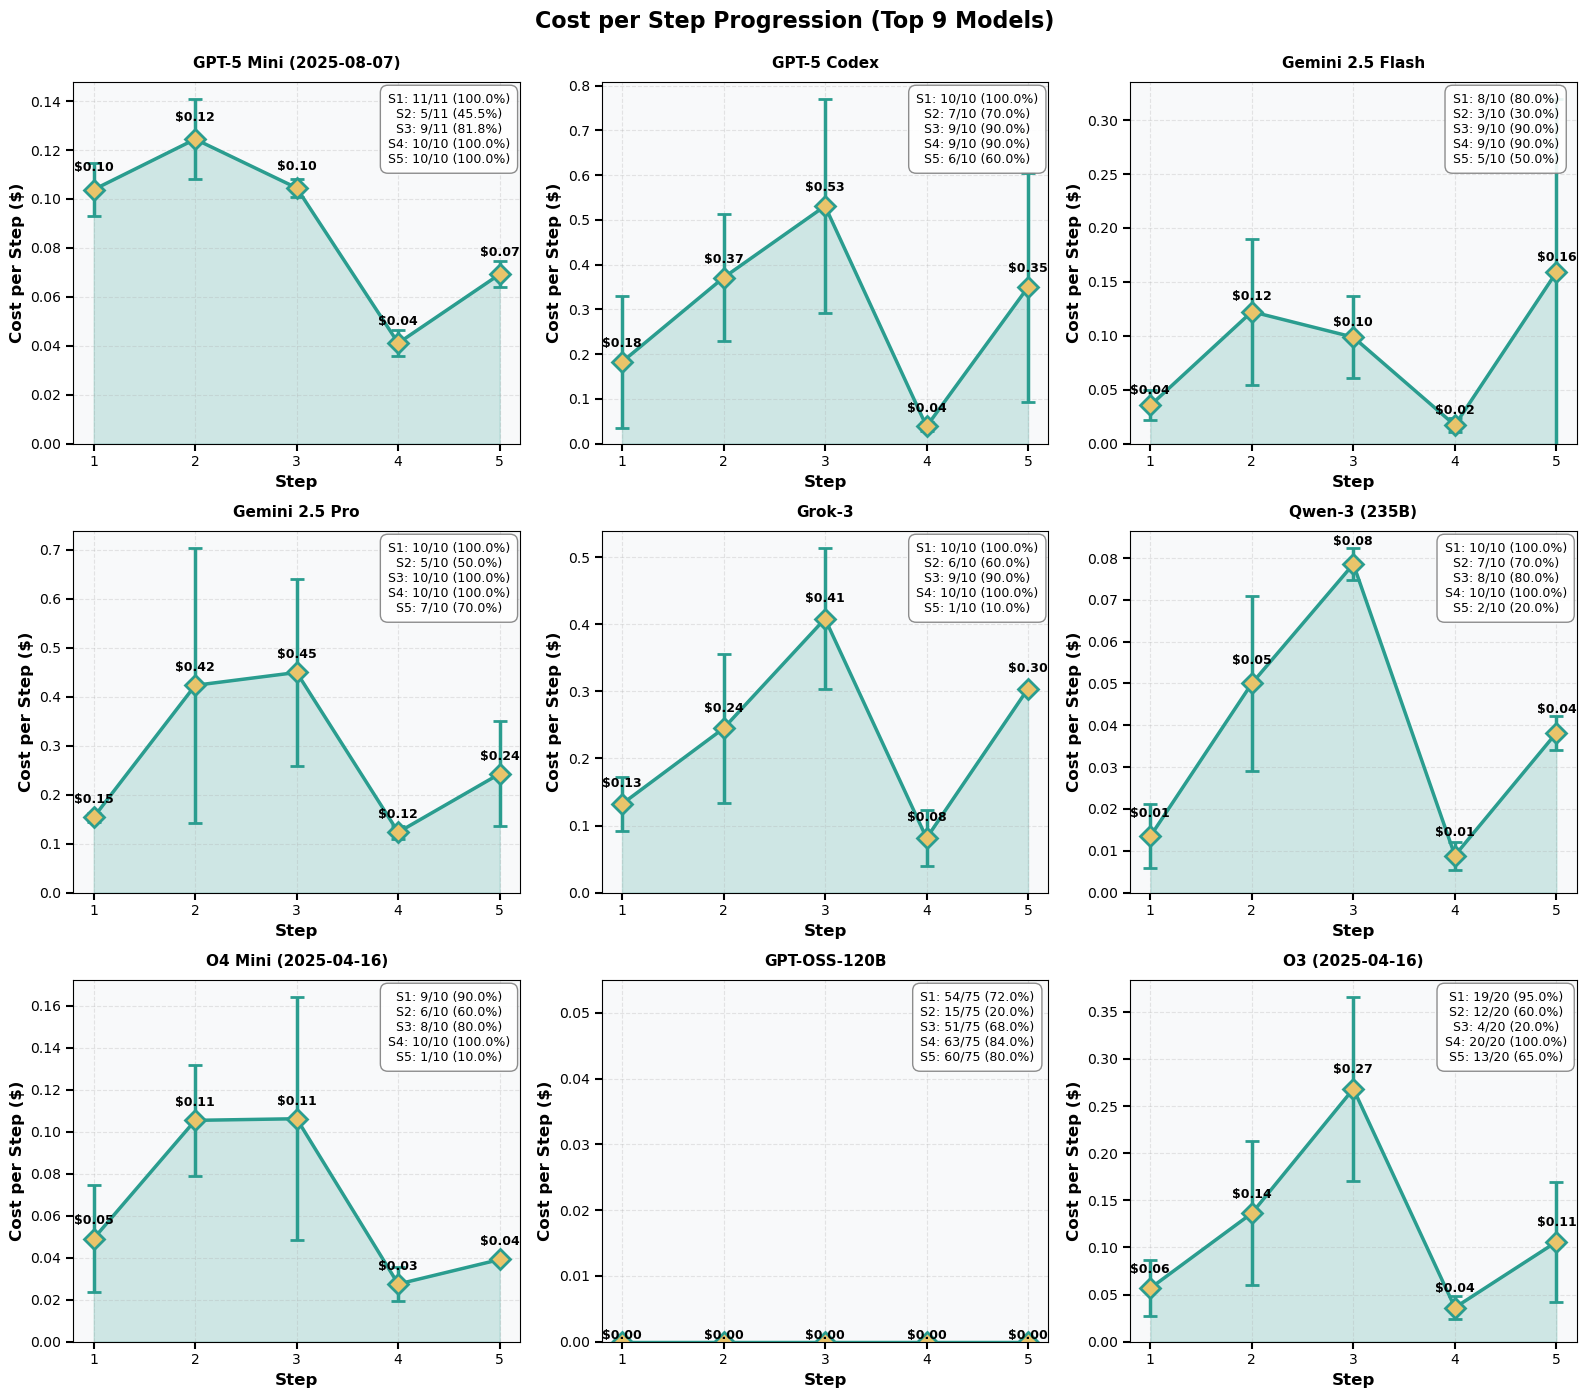

In [86]:
# Cost tables ($ per 1M tokens)
input_cost = {
    "openai/gpt-5": 1.25,
    "openai/gpt-5-mini": 0.25,
    "openai/o4-mini": 1.10,
    "google/gemini-pro": 1.25,
    "google/gemini:latest": 1.25,
    "google/gemini-2.0-flash-lite": 0.10,
    "gemini-2.0-flash-lite": 0.10,
    "google/gemini-flash": 0.30,
    "anthropic/claude-haiku": 0.80,
    "anthropic/claude-haiku:latest": 0.80,
    "claude-3-5-haiku-latest": 0.80,
    "anthropic/claude-opus": 15,
    "anthropic/claude-opus:latest": 15,
    "anthropic/claude-sonnet": 3.0,
    "anthropic/claude-sonnet:latest": 3.0,
    "xai/grok-code-fast-1": 0.20,
    "xai/grok:latest": 3,
    "openai/o3-mini": 1.10,
    "xai/grok-mini": 0.30,
    "openai/o3": 2,
    "openai/o:latest": 2,
    "deepseek-r1": 0.28,
    "gpt-5-codex": 1.25,  # Similar to gpt-5
    "gpt-oss-120b": 0.0,  # Free/open-source model
    "aws/llama-4-maverick": 0.50,  # AWS Llama pricing estimate
    "aws/llama-4-scout": 0.30,  # AWS Llama pricing estimate
    "gcp/qwen-3": 0.50,  # GCP Qwen pricing estimate
}

output_cost = {
    "openai/gpt-5": 10.0,
    "openai/gpt-5-mini": 2.0,
    "openai/o4-mini": 4.0,
    "google/gemini-pro": 10.0,
    "google/gemini:latest": 10.0,
    "google/gemini-2.0-flash-lite": 0.40,
    "gemini-2.0-flash-lite": 0.40,
    "google/gemini-flash": 2.50,
    "anthropic/claude-haiku": 0.80,
    "anthropic/claude-haiku:latest": 0.80,
    "claude-3-5-haiku-latest": 15,
    "anthropic/claude-opus": 75,
    "anthropic/claude-opus:latest": 75,
    "anthropic/claude-sonnet": 15.0,
    "anthropic/claude-sonnet:latest": 15.0,
    "xai/grok-code-fast-1": 1.50,
    "xai/grok:latest": 15,
    "openai/o3-mini": 4.40,
    "xai/grok-mini": 0.50,
    "openai/o3": 8,
    "openai/o:latest": 8,
    "deepseek-r1": 0.42,
    "gpt-5-codex": 10.0,  # Similar to gpt-5
    "gpt-oss-120b": 0.0,  # Free/open-source model
    "aws/llama-4-maverick": 2.0,  # AWS Llama pricing estimate
    "aws/llama-4-scout": 1.0,  # AWS Llama pricing estimate
    "gcp/qwen-3": 2.0,  # GCP Qwen pricing estimate
}

# Compute total price for each trial
def compute_total_price(row):
    sup_model = row['supervisor']
    cod_model = row['coder']
    sup_icost = input_cost.get(sup_model, 0)
    sup_ocost = output_cost.get(sup_model, 0)
    cod_icost = input_cost.get(cod_model, 0)
    cod_ocost = output_cost.get(cod_model, 0)
    sup_cost = (row['input_tokens']/1e6) * sup_icost + (row['output_tokens']/1e6) * sup_ocost
    cod_cost = (row['input_tokens']/1e6) * cod_icost + (row['output_tokens']/1e6) * cod_ocost
    return sup_cost + cod_cost

df_success['total_price'] = df_success.apply(compute_total_price, axis=1)

# Group by pair and step
cost_stats = (
    df_success.groupby(['pair', 'step'])['total_price']
    .agg(['mean', 'std'])
    .reset_index()
)

# Use the same top 9 pairs from Agent Work plot for consistency
top_pairs_cost = top_pairs

# Calculate success rates per step for each pair (for legend)
success_by_step_cost = (
    df[df['pair'].isin(top_pairs_cost)]
    .groupby(['pair', 'step'])
    .agg(
        n_success=('success', 'sum'),
        n_total=('success', 'count')
    )
    .reset_index()
)

# Create 3x3 faceted plot
fig, axes = plt.subplots(3, 3, figsize=(16, 14))
axes = axes.flatten()

for idx, pair in enumerate(top_pairs_cost):
    ax = axes[idx]
    pair_data = cost_stats[cost_stats['pair'] == pair].sort_values('step')
    
    # Plot cost per step with error bars - using green color scheme
    ax.errorbar(
        pair_data['step'],
        pair_data['mean'],
        yerr=pair_data['std'],
        marker='D',  # diamond markers
        color='#2A9D8F',  # teal/green color
        capsize=5,
        linewidth=2.5,
        markersize=10,
        markerfacecolor='#E9C46A',  # yellow fill
        markeredgewidth=2,
        markeredgecolor='#2A9D8F'
    )
    
    # Fill area under curve for visual effect
    ax.fill_between(pair_data['step'], 0, pair_data['mean'], alpha=0.2, color='#2A9D8F')
    
    # Add value labels on each point
    for _, row in pair_data.iterrows():
        ax.text(row['step'], row['mean'] + max(pair_data['mean']) * 0.05, 
               f"${row['mean']:.2f}", 
               ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Get success info per step for legend text box
    pair_success = success_by_step_cost[success_by_step_cost['pair'] == pair].sort_values('step')
    legend_text = []
    for _, row in pair_success.iterrows():
        step = int(row['step'])
        n_succ = int(row['n_success'])
        n_tot = int(row['n_total'])
        success_rate = (n_succ / n_tot * 100) if n_tot > 0 else 0
        legend_text.append(f"S{step}: {n_succ}/{n_tot} ({success_rate:.1f}%)")
    
    # Formatting with simple title
    ax.set_title(pair, fontsize=11, fontweight='bold', pad=10)
    ax.set_xlabel('Step', fontsize=12, fontweight='bold')
    ax.set_ylabel('Cost per Step ($)', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_xticks([1, 2, 3, 4, 5])
    ax.set_ylim(bottom=0)
    
    # Make tick labels more visible
    ax.tick_params(axis='both', which='major', labelsize=10, width=1.5, length=5)
    
    # Add text box with success rates per step, positioned between step 4 and 5
    textstr = '\n'.join(legend_text)
    props = dict(boxstyle='round,pad=0.6', facecolor='white', alpha=0.9, edgecolor='gray', linewidth=1)
    ax.text(4.5, ax.get_ylim()[1] * 0.97, textstr, fontsize=9,
            verticalalignment='top', horizontalalignment='center', bbox=props)
    
    # Add light background color
    ax.set_facecolor('#F8F9FA')

fig.suptitle('Cost per Step Progression (Top 9 Models)', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('plots/4_cost_per_step.png', dpi=300, bbox_inches='tight')
plt.savefig('plots/4_cost_per_step.pdf', bbox_inches='tight')
plt.show()


## 8. Export Summary Statistics

In [87]:
# Create comprehensive summary table
summary_stats = df_success.groupby(['pair', 'step']).agg({
    'success': 'count',
    'agent_work': ['mean', 'std'],
    'API_calls': ['mean', 'std'],
    'total_price': ['mean', 'std'],
    'duration': ['mean', 'std'],
    'input_tokens': 'mean',
    'output_tokens': 'mean'
}).round(2)

summary_stats.columns = ['_'.join(col).strip() for col in summary_stats.columns.values]
summary_stats = summary_stats.reset_index()

print("Summary statistics computed for all pairs and steps.")
print(f"Shape: {summary_stats.shape}")
summary_stats.head(15)

Summary statistics computed for all pairs and steps.
Shape: (45, 13)


pair  step  success_count  agent_work_mean  \
0               GPT-5 Codex   1.0             10            29.71   
1               GPT-5 Codex   2.0              7            15.51   
2               GPT-5 Codex   3.0              9            17.17   
3               GPT-5 Codex   4.0              9             6.20   
4               GPT-5 Codex   5.0              5            20.85   
5   GPT-5 Mini (2025-08-07)   1.0             11           103.92   
6   GPT-5 Mini (2025-08-07)   2.0              5            30.58   
7   GPT-5 Mini (2025-08-07)   3.0              9            20.20   
8   GPT-5 Mini (2025-08-07)   4.0             10            28.16   
9   GPT-5 Mini (2025-08-07)   5.0             10            25.21   
10             GPT-OSS-120B   1.0             54            12.57   
11             GPT-OSS-120B   2.0             15            12.23   
12             GPT-OSS-120B   3.0             51             9.31   
13             GPT-OSS-120B   4.0             63            11.27   
14             GPT-OSS-120B   5.0             60             9.57   

    agent_work_std  API_calls_mean  API_calls_std  total_price_mean  \
0            20.43            3.80           1.03              0.18   
1             5.66            4.43           1.51              0.37   
2             7.11            5.44           1.67              0.53   
3             1.69            3.44           0.88              0.04   
4            12.88            5.80           1.10              0.35   
5            11.06            7.00           0.00              0.10   
6             4.01            7.00           0.00              0.12   
7             0.69            7.00           0.00              0.10   
8             3.11            7.00           0.00              0.04   
9             1.89            7.00           0.00              0.07   
10            6.99            3.37           1.03              0.00   
11            6.96            4.60           2.03              0.00   
12            3.96            4.61           1.50              0.00   
13            6.03            4.75           1.74              0.00   
14            4.30            4.73           1.62              0.00   

    total_price_std  duration_mean  duration_std  input_tokens_mean  \
0              0.15         138.28         82.40            3084.60   
1              0.14         239.52         90.58           10528.29   
2              0.24         337.15        166.49           15786.22   
3              0.01         223.69        101.66            3291.00   
4              0.26         306.10        152.33            8801.20   
5              0.01         330.62         76.77           16302.55   
6              0.02         354.82         68.27           25173.40   
7              0.00         316.01         38.12           23718.78   
8              0.01         471.36         32.86           10257.80   
9              0.01         338.15         18.41           14457.30   
10             0.00          21.24         11.84            3410.41   
11             0.00          66.27         44.68           13648.13   
12             0.00          72.93         29.95           14005.53   
13             0.00         209.88        103.57            6150.71   
14             0.00          93.18         40.95            8075.18   

    output_tokens_mean  
0              8740.40  
1             17226.71  
2             24568.22  
3              1510.33  
4             16389.00  
5             23915.36  
6             27960.20  
7             23161.67  
8              8990.80  
9             15501.90  
10             2853.93  
11             9816.93  
12             9925.16  
13             3126.57  
14             5187.27

In [88]:
# Save summary to CSV
output_file = 'plots/five_step_summary_stats.csv'
summary_stats.to_csv(output_file, index=False)
print(f"Summary statistics saved to {output_file}")

Summary statistics saved to plots/five_step_summary_stats.csv
